@article{diode_dataset,
  title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
  author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and
  Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and
  Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
  journal={CoRR},
  volume={abs/1908.00463},
  year={2019},
  url={http ://arxiv.org/abs/1908.00463}
}

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(24)

In [2]:
annotation_folder = "/data/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 77s 0us/step


In [3]:
path = '/content/val/outdoor'

In [4]:
paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        paths.append(os.path.join(root, file))

In [5]:
paths = np.sort(paths)

In [6]:
len(paths)

1338

In [7]:
def enhance_depth_map1(depth_map , mask):
  depth_map = np.load(depth_map).squeeze()
  mask = np.load(mask)
  mask = mask > 0
  max_depth = min(300, np.percentile(depth_map, 99))
  depth_map = np.clip(depth_map, 0.1, max_depth)
  depth_map = np.log(depth_map, where=mask)
  depth_map = np.ma.masked_where(~mask, depth_map)
  depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
  depth_map = cv2.resize(depth_map, (512, 512))
  depth_map = np.expand_dims(depth_map, axis=2)
  depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
  return depth_map

In [8]:
from skimage import exposure

def enhance_depth_map2(depth_map_path, mask_path):
    # Load depth map and mask data
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    enhanced_depth_map = exposure.equalize_hist(depth_map, mask=mask)
    resized_depth_map = cv2.resize(enhanced_depth_map, (512, 512))
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)
    return converted_depth_map


In [9]:
def multi_scale_retinex(img, sigma_list, G, b, alpha, low_clip, high_clip):
    img = np.float64(img) + 1.0

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(img, (G, G), sigma)
        retinex = retinex + np.log10(img) - np.log10(gaussian)

    retinex = alpha * retinex

    retinex = np.where(retinex < low_clip, low_clip, retinex)
    retinex = np.where(retinex > high_clip, high_clip, retinex)

    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
    retinex = np.uint8(retinex)

    return retinex

def enhance_depth_map_retinex(depth_map_path, mask_path, target_size=(512, 512), sigma_list=(15, 80, 250), G=15, b=25, alpha=125, low_clip=0, high_clip=255):
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    enhanced_depth_map = multi_scale_retinex(depth_map, sigma_list, G, b, alpha, low_clip, high_clip)
    resized_depth_map = cv2.resize(enhanced_depth_map, target_size)
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)

    return converted_depth_map


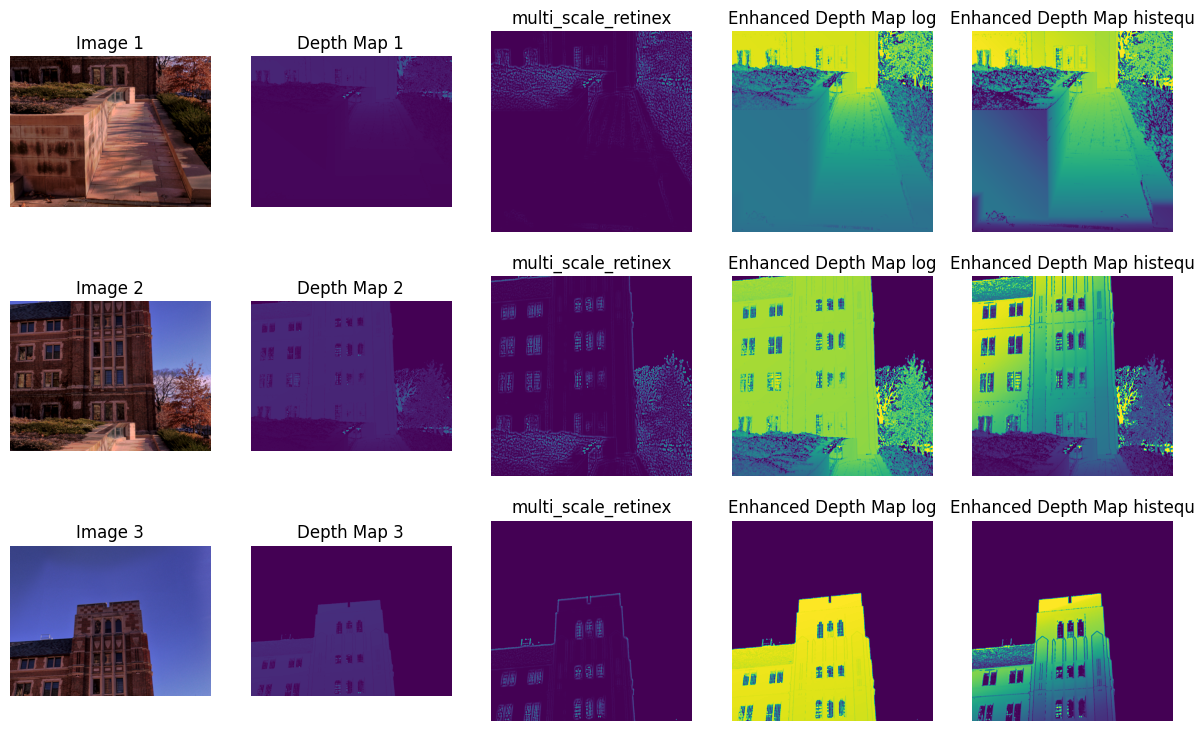

In [10]:
image_paths = [paths[i] for i in range(0 , 8 , 3)]  # Example image paths
depth_arrays = [np.load(paths[i+1]) for i in range(0 , 8 , 3)]
depth_mask_arrays = [np.load(paths[i+2]) for i in range(0 , 8 , 3)]
depth1 = [enhance_depth_map1(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth2 = [enhance_depth_map2(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth3 = [enhance_depth_map_retinex(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]

fig, axes = plt.subplots(len(image_paths), 5, figsize=(15, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(len(image_paths)):
    image = plt.imread(image_paths[i])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_arrays[i], cmap='viridis')
    axes[i, 1].set_title('Depth Map {}'.format(i + 1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(depth3[i], cmap='viridis')
    axes[i, 2].set_title('multi_scale_retinex')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(depth1[i], cmap='viridis')
    axes[i, 3].set_title('Enhanced Depth Map log')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(depth2[i], cmap='viridis')
    axes[i, 4].set_title('Enhanced Depth Map histequ')
    axes[i, 4].axis('off')



plt.show()


so the hist Histogram Equalization is choosed

In [11]:
files = []
depth_files = []
mask_files = []
for i in range(0 , len(paths)-2 , 3):
  files.append(paths[i])
  depth_files.append(paths[i+1])
  mask_files.append(paths[i+2])

In [12]:
len(files) , len(depth_files) , len(mask_files)

(446, 446, 446)

In [13]:
np.load(mask_files[0]).shape

(768, 1024)

In [14]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_images, list_depth_maps, list_masks, batch_size=5, dim=(512, 512), n_channels=1, shuffle=True):
        """
        Initialization
        """
        self.list_images = list_images
        self.indices = range(len(self.list_images))
        self.list_depth_maps = list_depth_maps
        self.list_masks = list_masks
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.dim = dim
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.list_images) / float(self.batch_size)))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_path, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = enhance_depth_map2(depth_path , mask)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.list_images[batch_id],
                self.list_depth_maps[batch_id],
                self.list_masks[batch_id],
            )

        return x, y

In [15]:
data_generator = CustomDataGenerator(files , depth_files , mask_files, batch_size=5 ,dim=(512, 512), n_channels=3, shuffle=True)

# Access batches using data_generator[i]
# Example:
batch_images, batch_depth_maps =  data_generator.__getitem__(20)

In [16]:
batch_images.shape , batch_depth_maps.shape

((5, 512, 512, 3), (5, 512, 512, 1))

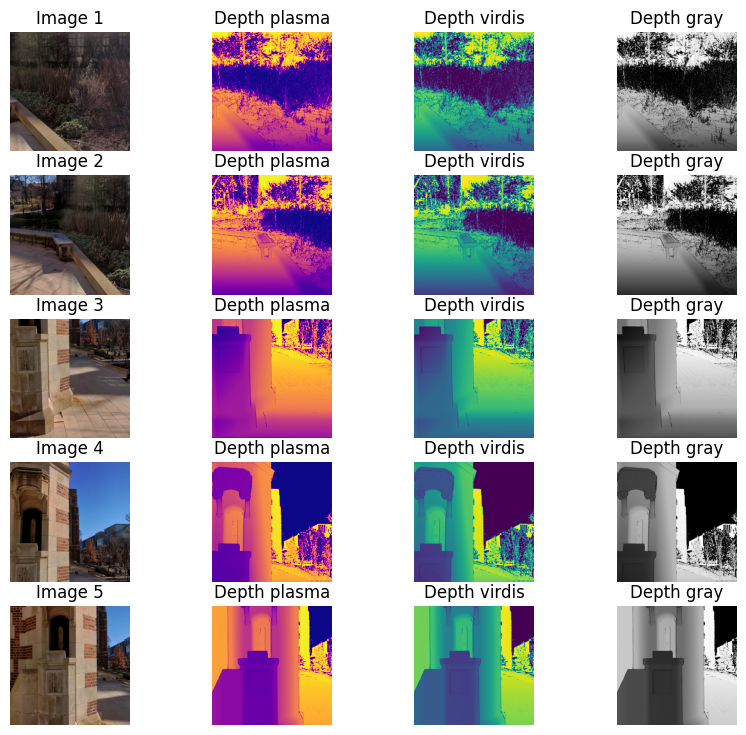

In [17]:
image_to_visualize = batch_images[:5]
depth_map_to_visualize = batch_depth_maps[:5]

fig, axes = plt.subplots(5, 4, figsize=(10, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(5):
    axes[i, 0].imshow(batch_images[i] , cmap='jet')
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch_depth_maps[i] , cmap='plasma')
    axes[i, 1].set_title('Depth plasma')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(batch_depth_maps[i] , cmap='viridis')
    axes[i, 2].set_title('Depth virdis')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(batch_depth_maps[i] , cmap='gray')
    axes[i, 3].set_title('Depth gray')
    axes[i, 3].axis('off')


# in progress...

---



---

---



---





---



# The model

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D

# Define the input shape
input_shape = (512, 512, 3)  # Assuming you have RGB images

# Load the pre-trained ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create the encoder using ResNet-50
encoder_output = base_model.output

# Define the decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_output)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the monocular depth estimation model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with an appropriate loss and optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print a summary of the model architecture
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [34]:
# import tensorflow as tf
# from tensorflow.keras.utils import get_custom_objects
# from tensorflow.image import ssim
# import tensorflow.keras.backend as K

# # Define the custom loss function that combines SSIM and Huber loss
# def custom_loss(y_true, y_pred):
#     alpha = 0.85  # Weight for the SSIM loss
#     beta = 0.15   # Weight for the Huber loss

#     # Compute the SSIM loss
#     ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)

#     # Compute the Huber loss
#     huber_loss = tf.keras.losses.Huber()(y_true, y_pred)

#     # Combine the SSIM and Huber loss
#     total_loss = alpha * ssim_loss + beta * huber_loss
#     return total_loss

# # Register the custom loss function with get_custom_objects
# get_custom_objects().update({'custom_loss': custom_loss})

# # Compile the model with the custom loss function
# model.compile(loss=custom_loss, optimizer='adam')


In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

model.fit(data_generator, epochs=100, steps_per_epoch=10,callbacks=[reduce_lr])


Epoch 1/100
10/10 [==============================] - 2s 200ms/step - loss: 0.0961 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 1s 116ms/step - loss: 0.1017 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 1s 123ms/step - loss: 0.1028 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 2s 184ms/step - loss: 0.1010 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 1s 139ms/step - loss: 0.1028 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 1s 132ms/step - loss: 0.0895 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 1s 119ms/step - loss: 0.0947 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - 1s 118ms/step - loss: 0.1122 - lr: 0.0010
Epoch 9/100
10/10 [==============================] - 1s 117ms/step - loss: 0.1000 - lr: 0.0010
Epoch 10/100
10/10 [==============================] - 2s 171ms/step - loss: 0.1035 - lr: 0.0010
Epoch 11/100
10/10 [=============================

In [21]:
image_to_visualize = batch_images[:5]
depth_map_to_visualize = batch_depth_maps[:5]

In [44]:
y = model.predict(image_to_visualize)

1/1 [==============================] - 0s 35ms/step


Exception ignored in: <function _xla_gc_callback at 0x787bbf195510>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


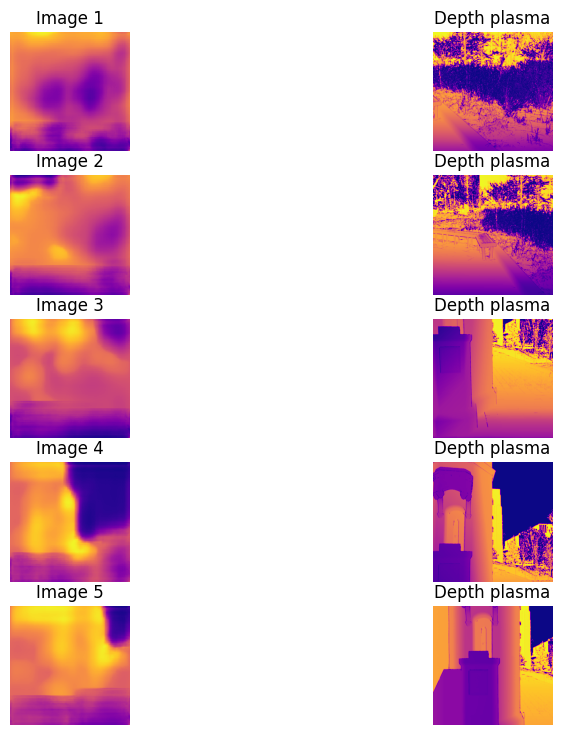

In [45]:
depth_map_to_visualize = batch_depth_maps[:5]

fig, axes = plt.subplots(5, 2, figsize=(10, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(5):
    axes[i, 0].imshow(y[i] , cmap='plasma')
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch_depth_maps[i] , cmap='plasma')
    axes[i, 1].set_title('Depth plasma')
    axes[i, 1].axis('off')

